DEEP Q-LEARNING EXPLAINED

1. WHAT YOU ALREADY KNOW: Q-LEARNING RECAP

Q-learning uses a Q-table where each entry Q(s,a) stores the expected 
future reward for taking action 'a' in state 's'.

Update rule:
Q(s,a) ← Q(s,a) + α[r + γ·max_a' Q(s',a') - Q(s,a)]

Where:
- α = learning rate (how much to update)
- r = immediate reward
- γ = discount factor (how much future matters)
- s' = next state
- max_a' Q(s',a') = best Q-value in next state


Simple Q-table example (5 states, 2 actions):
[[-0.15344813 -1.06611086]
 [-0.31808846  0.47981551]
 [-1.27375878  0.515215  ]
 [ 1.59036291 -0.81738378]
 [-0.35175929 -0.22697065]]

Q-table size: 10 entries

2. THE PROBLEM: Q-TABLES DON'T SCALE

Q-tables work for small state spaces. But what happens when states explode?

Example scenarios:
- Atari game: 210×160 pixels, 128 colors = astronomical states
- Robot control: continuous joint angles and velocities
- Chess: ~10^43 possible board positions


[GRAPH SAVED: q_table_growth.png]
Notice the explo

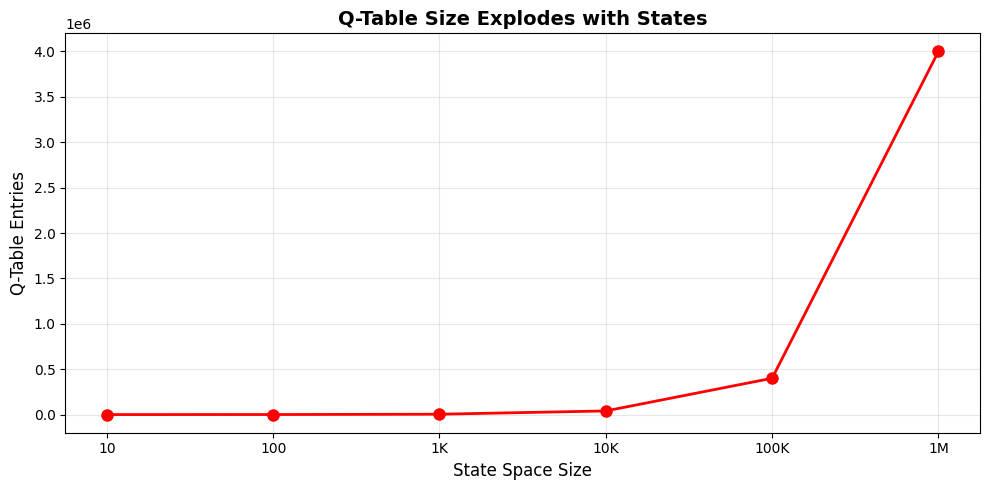


THE CORE PROBLEMS:
1. MEMORY: Can't store billions of Q-values
2. LEARNING TIME: Must visit each state-action pair many times
3. NO GENERALIZATION: Seeing one state doesn't help with similar states

3. THE SOLUTION: FUNCTION APPROXIMATION

KEY INSIGHT: Similar states should have similar Q-values.

Instead of storing Q(s,a) for every state-action pair, use a FUNCTION 
to approximate it:

    Q(s,a) ≈ Neural_Network(s)[a]

The network GENERALIZES. If it learns Q-values for state s1=[10, 5], 
it can estimate Q-values for s2=[10.1, 5.1] without ever visiting s2.


Visualizing function approximation:
[GRAPH SAVED: function_approximation.png]


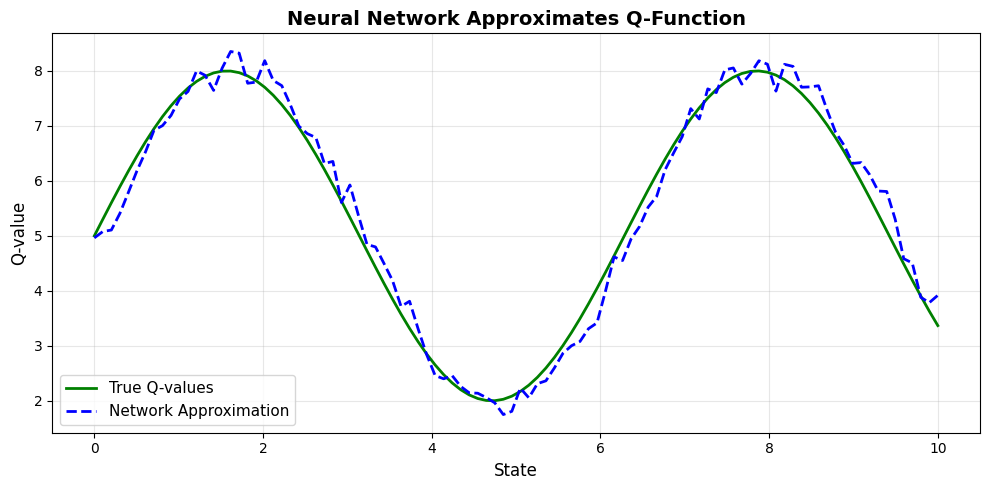


The network won't be perfect, but it generalizes to unseen states!

4. DEEP Q-NETWORK (DQN) ARCHITECTURE

A DQN is a neural network with specific input/output structure:

    [State] → [Hidden Layers] → [Q-value for each action]

Example for Atari Pong:
- INPUT: 84×84 grayscale image (game screen)
- HIDDEN: Convolutional layers (detect paddles, ball)
- OUTPUT: 6 values (one per action: up, down, left, right, fire, no-op)

WHY OUTPUT ALL ACTIONS AT ONCE?
We only need one forward pass to choose the best action. Efficient!

We write Q(s,a;θ) where θ = network parameters (weights).


Example: Simple Q-network
State: [ 0.5 -0.1  0.2  0.3]
Q-values: [-0.02551606 -0.03238817]
Best action: 0

5. TRAINING THE NETWORK

In Q-learning, you updated the table directly. With a neural network, 
you update weights through GRADIENT DESCENT.

STEP 1: DEFINE LOSS FUNCTION
Target = r + γ·max_a' Q(s',a';θ)
Loss = (Target - Q(s,a;θ))²

STEP 2: EXPERIENCE REPLAY
Neural networks assume training data is i.i.d.

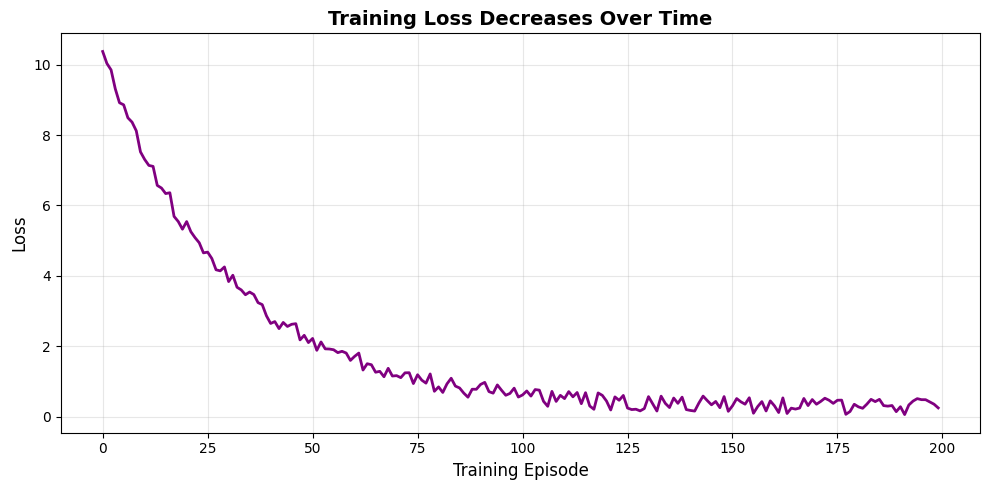


As training progresses, network predictions get closer to target values, 
and loss decreases.


6. WHY THESE TECHNIQUES MATTER (THE LOGIC)

EXPERIENCE REPLAY:
- WITHOUT IT: Network sees s1, then s2, then s3 in sequence. 
  It overfits to recent experiences and forgets earlier ones.
- WITH IT: Network trains on random mix of old and new experiences.
  Improves data efficiency and stability.

TARGET NETWORK:
- WITHOUT IT: Target = r + γ·max Q(s',a';θ). As θ changes, target changes.
  This causes oscillations - like trying to hit a moving target.
- WITH IT: Target uses θ⁻, frozen for many steps. Stable learning signal.

FUNCTION APPROXIMATION:
- BENEFIT: Learn from one state, generalize to similar states.
  Can handle continuous or huge state spaces.
- TRADEOFF: May not converge to exact optimal policy (approximation error),
  but works in problems where Q-learning cannot even run.


Visualizing why target network matters:
[GRAPH SAVED: target_network_stability.png]


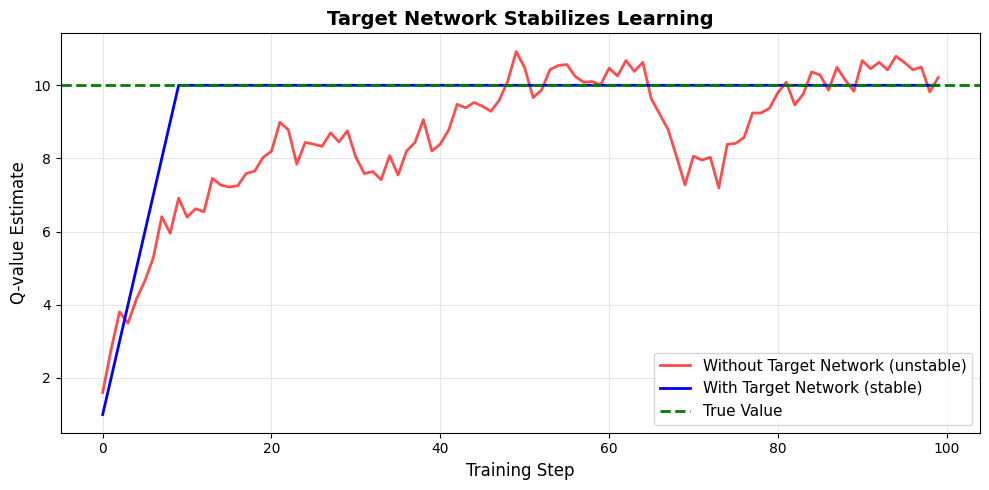


7. WHAT DEEP Q-LEARNING CAN DO

DQN made reinforcement learning practical for complex problems:

APPLICATIONS:
1. VIDEO GAMES: DeepMind's DQN learned to play 49 Atari games from pixels,
   reaching human-level performance on many.

2. ROBOTICS: Robot arms learning to grasp objects, manipulate tools, or
   navigate spaces using high-dimensional sensor inputs.

3. RESOURCE MANAGEMENT: Optimizing data center cooling, traffic light timing,
   or inventory control with many variables.

4. RECOMMENDATION SYSTEMS: Sequential decision making for content recommendations,
   where state = user history and actions = items to recommend.

LIMITATIONS:
1. SAMPLE EFFICIENCY: DQN needs millions of experiences to learn.
2. DISCRETE ACTIONS ONLY: Standard DQN works with discrete action spaces
   (e.g., left/right/jump), not continuous (e.g., steering angle 0-360°).
3. OVERESTIMATION BIAS: Taking max over Q-values tends to overestimate,
   though improvements like Double DQN address this.


Comparing le

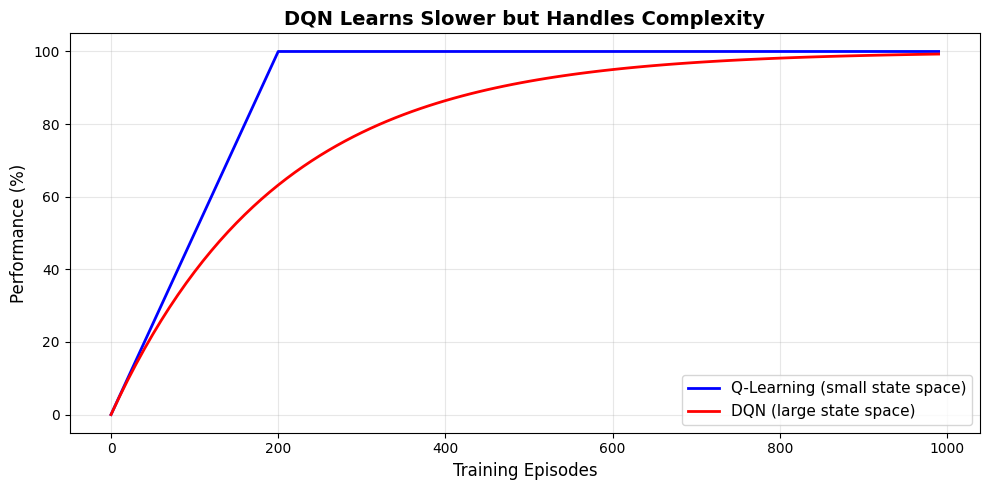


SUMMARY: FROM Q-LEARNING TO DEEP Q-LEARNING

Q-LEARNING:
- Store Q(s,a) in a table
- Update using Bellman equation
- Works for small state spaces
- Guarantees convergence to optimal policy

DEEP Q-LEARNING:
- Approximate Q(s,a) with neural network
- Train using gradient descent on (target - prediction)²
- Use experience replay for stable training
- Use target network for stable targets
- Works for large/continuous state spaces
- Trades exact optimality for scalability

CORE TRADEOFF:
Q-learning guarantees convergence to optimal policy in tabular case.
DQN trades exact optimality for the ability to solve problems that 
Q-learning cannot even represent.

THE KEY INSIGHT:
Similar states should have similar Q-values. A neural network can learn
these patterns and GENERALIZE to unseen states. This is why DQN works
where Q-tables fail.


All graphs saved! Review them to see the logic visually.


In [3]:
"""
Deep Q-Learning: From Q-Learning to Neural Networks
A Python notebook building on Q-learning knowledge
"""

import numpy as np
import matplotlib.pyplot as plt
from collections import deque
import random

print("="*70)
print("DEEP Q-LEARNING EXPLAINED")
print("="*70)

# ============================================================================
# SECTION 1: Q-LEARNING RECAP
# ============================================================================
print("\n" + "="*70)
print("1. WHAT YOU ALREADY KNOW: Q-LEARNING RECAP")
print("="*70)

print("""
Q-learning uses a Q-table where each entry Q(s,a) stores the expected 
future reward for taking action 'a' in state 's'.

Update rule:
Q(s,a) ← Q(s,a) + α[r + γ·max_a' Q(s',a') - Q(s,a)]

Where:
- α = learning rate (how much to update)
- r = immediate reward
- γ = discount factor (how much future matters)
- s' = next state
- max_a' Q(s',a') = best Q-value in next state
""")

# Simple Q-learning example
print("\nSimple Q-table example (5 states, 2 actions):")
q_table = np.random.randn(5, 2)
print(q_table)
print(f"\nQ-table size: {q_table.size} entries")

# ============================================================================
# SECTION 2: THE PROBLEM - Q-TABLES DON'T SCALE
# ============================================================================
print("\n" + "="*70)
print("2. THE PROBLEM: Q-TABLES DON'T SCALE")
print("="*70)

print("""
Q-tables work for small state spaces. But what happens when states explode?

Example scenarios:
- Atari game: 210×160 pixels, 128 colors = astronomical states
- Robot control: continuous joint angles and velocities
- Chess: ~10^43 possible board positions
""")

# Visualize Q-table growth
states_list = [10, 100, 1000, 10000, 100000, 1000000]
actions = 4
entries = [s * actions for s in states_list]

plt.figure(figsize=(10, 5))
plt.plot(range(len(states_list)), entries, 'ro-', linewidth=2, markersize=8)
plt.xlabel('State Space Size', fontsize=12)
plt.ylabel('Q-Table Entries', fontsize=12)
plt.title('Q-Table Size Explodes with States', fontsize=14, fontweight='bold')
plt.xticks(range(len(states_list)), ['10', '100', '1K', '10K', '100K', '1M'])
plt.grid(True, alpha=0.3)
plt.ticklabel_format(style='scientific', axis='y', scilimits=(0,0))
plt.tight_layout()
plt.savefig('q_table_growth.png', dpi=150, bbox_inches='tight')
print("\n[GRAPH SAVED: q_table_growth.png]")
print("Notice the explosive growth - from 40 entries to 4 MILLION entries!")
plt.show()

print("\nTHE CORE PROBLEMS:")
print("1. MEMORY: Can't store billions of Q-values")
print("2. LEARNING TIME: Must visit each state-action pair many times")
print("3. NO GENERALIZATION: Seeing one state doesn't help with similar states")

# ============================================================================
# SECTION 3: THE SOLUTION - FUNCTION APPROXIMATION
# ============================================================================
print("\n" + "="*70)
print("3. THE SOLUTION: FUNCTION APPROXIMATION")
print("="*70)

print("""
KEY INSIGHT: Similar states should have similar Q-values.

Instead of storing Q(s,a) for every state-action pair, use a FUNCTION 
to approximate it:

    Q(s,a) ≈ Neural_Network(s)[a]

The network GENERALIZES. If it learns Q-values for state s1=[10, 5], 
it can estimate Q-values for s2=[10.1, 5.1] without ever visiting s2.
""")

# Demonstrate function approximation
print("\nVisualizing function approximation:")

# True Q-function (unknown in practice)
x_states = np.linspace(0, 10, 100)
true_q_values = np.sin(x_states) * 3 + 5

# Neural network approximation (with some error)
approx_q_values = np.sin(x_states - 0.1) * 3 + 5 + np.random.randn(100) * 0.2

plt.figure(figsize=(10, 5))
plt.plot(x_states, true_q_values, 'g-', linewidth=2, label='True Q-values')
plt.plot(x_states, approx_q_values, 'b--', linewidth=2, label='Network Approximation')
plt.xlabel('State', fontsize=12)
plt.ylabel('Q-value', fontsize=12)
plt.title('Neural Network Approximates Q-Function', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('function_approximation.png', dpi=150, bbox_inches='tight')
print("[GRAPH SAVED: function_approximation.png]")
plt.show()

print("\nThe network won't be perfect, but it generalizes to unseen states!")

# ============================================================================
# SECTION 4: DEEP Q-NETWORK ARCHITECTURE
# ============================================================================
print("\n" + "="*70)
print("4. DEEP Q-NETWORK (DQN) ARCHITECTURE")
print("="*70)

print("""
A DQN is a neural network with specific input/output structure:

    [State] → [Hidden Layers] → [Q-value for each action]

Example for Atari Pong:
- INPUT: 84×84 grayscale image (game screen)
- HIDDEN: Convolutional layers (detect paddles, ball)
- OUTPUT: 6 values (one per action: up, down, left, right, fire, no-op)

WHY OUTPUT ALL ACTIONS AT ONCE?
We only need one forward pass to choose the best action. Efficient!

We write Q(s,a;θ) where θ = network parameters (weights).
""")

# Simple neural network structure
class SimpleQNetwork:
    """Simplified Q-network for demonstration"""
    def __init__(self, state_size, action_size, hidden_size=64):
        self.state_size = state_size
        self.action_size = action_size
        
        # Initialize weights randomly (in practice, use proper initialization)
        self.W1 = np.random.randn(state_size, hidden_size) * 0.1
        self.b1 = np.zeros(hidden_size)
        self.W2 = np.random.randn(hidden_size, action_size) * 0.1
        self.b2 = np.zeros(action_size)
    
    def forward(self, state):
        """Forward pass through network"""
        # Hidden layer with ReLU activation
        hidden = np.maximum(0, np.dot(state, self.W1) + self.b1)
        # Output layer
        q_values = np.dot(hidden, self.W2) + self.b2
        return q_values

# Create and test network
print("\nExample: Simple Q-network")
state_size = 4  # e.g., cart position, velocity, pole angle, pole velocity
action_size = 2  # e.g., push left or right
network = SimpleQNetwork(state_size, action_size)

test_state = np.array([0.5, -0.1, 0.2, 0.3])
q_values = network.forward(test_state)
print(f"State: {test_state}")
print(f"Q-values: {q_values}")
print(f"Best action: {np.argmax(q_values)}")

# ============================================================================
# SECTION 5: TRAINING THE NETWORK
# ============================================================================
print("\n" + "="*70)
print("5. TRAINING THE NETWORK")
print("="*70)

print("""
In Q-learning, you updated the table directly. With a neural network, 
you update weights through GRADIENT DESCENT.

STEP 1: DEFINE LOSS FUNCTION
Target = r + γ·max_a' Q(s',a';θ)
Loss = (Target - Q(s,a;θ))²

STEP 2: EXPERIENCE REPLAY
Neural networks assume training data is i.i.d. (independent and identically 
distributed). But in RL, consecutive experiences are correlated.

SOLUTION: Store experiences in a replay buffer.
Each experience = (state, action, reward, next_state, done)

During training, randomly sample a BATCH from this buffer. This breaks 
correlation and stabilizes learning.

STEP 3: TARGET NETWORK
PROBLEM: Using same network for current Q and target Q creates moving target.

SOLUTION: Use TWO networks:
- Online network (θ): Updated every step
- Target network (θ⁻): Copy of online network, updated every N steps

Target = r + γ·max_a' Q(s',a';θ⁻)

This gives target time to stabilize while online network learns.
""")

# Implement experience replay buffer
class ReplayBuffer:
    """Stores and samples experiences for training"""
    def __init__(self, capacity):
        self.buffer = deque(maxlen=capacity)
    
    def add(self, state, action, reward, next_state, done):
        """Add experience to buffer"""
        self.buffer.append((state, action, reward, next_state, done))
    
    def sample(self, batch_size):
        """Randomly sample batch of experiences"""
        batch = random.sample(self.buffer, batch_size)
        states, actions, rewards, next_states, dones = zip(*batch)
        return (np.array(states), np.array(actions), np.array(rewards),
                np.array(next_states), np.array(dones))
    
    def __len__(self):
        return len(self.buffer)

# Demonstrate replay buffer
print("\nExample: Experience Replay Buffer")
replay_buffer = ReplayBuffer(capacity=10000)

# Add some fake experiences
for i in range(100):
    state = np.random.randn(4)
    action = random.randint(0, 1)
    reward = random.random()
    next_state = np.random.randn(4)
    done = random.random() < 0.1
    replay_buffer.add(state, action, reward, next_state, done)

print(f"Buffer size: {len(replay_buffer)}")
print("\nSample batch of 5 experiences:")
states, actions, rewards, next_states, dones = replay_buffer.sample(5)
for i in range(5):
    print(f"  Experience {i+1}: action={actions[i]}, reward={rewards[i]:.3f}, done={dones[i]}")

# Simulate training loss over time
print("\nSimulating training loss over episodes:")
episodes = 200
losses = []
for episode in range(episodes):
    # Loss decreases exponentially with noise
    loss = 10 * np.exp(-episode/30) + np.random.rand() * 0.5
    losses.append(loss)

plt.figure(figsize=(10, 5))
plt.plot(losses, 'purple', linewidth=2)
plt.xlabel('Training Episode', fontsize=12)
plt.ylabel('Loss', fontsize=12)
plt.title('Training Loss Decreases Over Time', fontsize=14, fontweight='bold')
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('training_loss.png', dpi=150, bbox_inches='tight')
print("[GRAPH SAVED: training_loss.png]")
plt.show()

print("""
As training progresses, network predictions get closer to target values, 
and loss decreases.
""")

# ============================================================================
# SECTION 6: WHY THESE TECHNIQUES MATTER
# ============================================================================
print("\n" + "="*70)
print("6. WHY THESE TECHNIQUES MATTER (THE LOGIC)")
print("="*70)

print("""
EXPERIENCE REPLAY:
- WITHOUT IT: Network sees s1, then s2, then s3 in sequence. 
  It overfits to recent experiences and forgets earlier ones.
- WITH IT: Network trains on random mix of old and new experiences.
  Improves data efficiency and stability.

TARGET NETWORK:
- WITHOUT IT: Target = r + γ·max Q(s',a';θ). As θ changes, target changes.
  This causes oscillations - like trying to hit a moving target.
- WITH IT: Target uses θ⁻, frozen for many steps. Stable learning signal.

FUNCTION APPROXIMATION:
- BENEFIT: Learn from one state, generalize to similar states.
  Can handle continuous or huge state spaces.
- TRADEOFF: May not converge to exact optimal policy (approximation error),
  but works in problems where Q-learning cannot even run.
""")

# Demonstrate instability without target network
print("\nVisualizing why target network matters:")

episodes = 100
q_values_no_target = []
q_values_with_target = []

# Simulate Q-value updates
q_current = 0.0
q_with_target = 0.0
target_q = 0.0

for episode in range(episodes):
    true_value = 10.0  # What we're trying to learn
    
    # Without target network: both current and target change every step
    q_current += 0.1 * (true_value - q_current) + np.random.randn() * 0.5
    q_values_no_target.append(q_current)
    
    # With target network: target updates every 10 steps
    if episode % 10 == 0:
        target_q = q_with_target
    q_with_target += 0.1 * (true_value - target_q)
    q_values_with_target.append(q_with_target)

plt.figure(figsize=(10, 5))
plt.plot(q_values_no_target, 'r-', alpha=0.7, linewidth=2, label='Without Target Network (unstable)')
plt.plot(q_values_with_target, 'b-', linewidth=2, label='With Target Network (stable)')
plt.axhline(y=10.0, color='g', linestyle='--', linewidth=2, label='True Value')
plt.xlabel('Training Step', fontsize=12)
plt.ylabel('Q-value Estimate', fontsize=12)
plt.title('Target Network Stabilizes Learning', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('target_network_stability.png', dpi=150, bbox_inches='tight')
print("[GRAPH SAVED: target_network_stability.png]")
plt.show()

# ============================================================================
# SECTION 7: WHAT DEEP Q-LEARNING CAN DO
# ============================================================================
print("\n" + "="*70)
print("7. WHAT DEEP Q-LEARNING CAN DO")
print("="*70)

print("""
DQN made reinforcement learning practical for complex problems:

APPLICATIONS:
1. VIDEO GAMES: DeepMind's DQN learned to play 49 Atari games from pixels,
   reaching human-level performance on many.

2. ROBOTICS: Robot arms learning to grasp objects, manipulate tools, or
   navigate spaces using high-dimensional sensor inputs.

3. RESOURCE MANAGEMENT: Optimizing data center cooling, traffic light timing,
   or inventory control with many variables.

4. RECOMMENDATION SYSTEMS: Sequential decision making for content recommendations,
   where state = user history and actions = items to recommend.

LIMITATIONS:
1. SAMPLE EFFICIENCY: DQN needs millions of experiences to learn.
2. DISCRETE ACTIONS ONLY: Standard DQN works with discrete action spaces
   (e.g., left/right/jump), not continuous (e.g., steering angle 0-360°).
3. OVERESTIMATION BIAS: Taking max over Q-values tends to overestimate,
   though improvements like Double DQN address this.
""")

# Visualize sample efficiency comparison
print("\nComparing learning efficiency:")

episodes = np.arange(0, 1000, 10)
q_learning_performance = np.minimum(100, episodes * 0.5)  # Fast for small problems
dqn_performance = 100 * (1 - np.exp(-episodes/200))  # Slow start, handles complexity

plt.figure(figsize=(10, 5))
plt.plot(episodes, q_learning_performance, 'b-', linewidth=2, label='Q-Learning (small state space)')
plt.plot(episodes, dqn_performance, 'r-', linewidth=2, label='DQN (large state space)')
plt.xlabel('Training Episodes', fontsize=12)
plt.ylabel('Performance (%)', fontsize=12)
plt.title('DQN Learns Slower but Handles Complexity', fontsize=14, fontweight='bold')
plt.legend(fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig('learning_efficiency.png', dpi=150, bbox_inches='tight')
print("[GRAPH SAVED: learning_efficiency.png]")
plt.show()

# ============================================================================
# SECTION 8: SUMMARY
# ============================================================================
print("\n" + "="*70)
print("SUMMARY: FROM Q-LEARNING TO DEEP Q-LEARNING")
print("="*70)

print("""
Q-LEARNING:
- Store Q(s,a) in a table
- Update using Bellman equation
- Works for small state spaces
- Guarantees convergence to optimal policy

DEEP Q-LEARNING:
- Approximate Q(s,a) with neural network
- Train using gradient descent on (target - prediction)²
- Use experience replay for stable training
- Use target network for stable targets
- Works for large/continuous state spaces
- Trades exact optimality for scalability

CORE TRADEOFF:
Q-learning guarantees convergence to optimal policy in tabular case.
DQN trades exact optimality for the ability to solve problems that 
Q-learning cannot even represent.

THE KEY INSIGHT:
Similar states should have similar Q-values. A neural network can learn
these patterns and GENERALIZE to unseen states. This is why DQN works
where Q-tables fail.
""")

print("\n" + "="*70)
print("All graphs saved! Review them to see the logic visually.")
print("="*70)